# IMPORT LIBRARIES

In [23]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# LOAD DATA

In [25]:
df_owid = pd.read_csv('/content/owid-co2-data.csv')

In [26]:
df_owid.shape

(50598, 79)

### CO2 Emissions over Time

In [27]:
# Line plot of CO2 emissions over time for a specific country using Plotly
def plot_co2_lineplot(df, country_name):
    country_df = df[df['country'] == country_name]

    # Create the Plotly figure
    fig = go.Figure()

    # Add the line plot for CO2 emissions over time
    fig.add_trace(go.Scatter(
        x=country_df['year'],
        y=country_df['co2'],
        mode='markers+lines',
        marker=dict(size=5),
        line=dict(width=2),
        name='CO2 Emissions'
    ))

    # Update the layout
    fig.update_layout(
        title=f'CO2 Emissions over Time for {country_name}',
        xaxis_title='Year',
        yaxis_title='CO2 Emissions (Million Tonnes)',
        showlegend=True,
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
    )

    # Show the Plotly figure
    fig.show()

In [28]:
plot_co2_lineplot(df_owid, 'World')

In [29]:
# Only taking data from 1900
df_owid_1900_onwards = df_owid[(df_owid['year'] >= 1900) & (df_owid['country'] == 'World')]

In [30]:
df_owid_1900_onwards = df_owid_1900_onwards[['year', 'co2']]

In [31]:
# Convert 'year' column to datetime format
df_owid_1900_onwards['year'] = pd.to_datetime(df_owid_1900_onwards['year'], format='%Y')

In [32]:
# Set 'year' as the index
df_owid_1900_onwards.set_index('year', inplace=True)

In [33]:
# Split data into training (1900-2010) and testing (2011-2019) sets
train_data = df_owid_1900_onwards.loc['1900':'2010']
test_data = df_owid_1900_onwards.loc['2011':'2019']

In [34]:
train_data

,co2
year,
1900-01-01,1952.209
1901-01-01,2016.744
1902-01-01,2067.684
1903-01-01,2254.095
1904-01-01,2279.749
...,...
2006-01-01,30593.117
2007-01-01,31506.789
2008-01-01,32085.836


In [35]:
# ARIMA Model
def arima_model(train_data, test_data):
    model = ARIMA(train_data, order=(p, d, q))
    model_fit = model.fit()
    forecast = model_fit.forecast(len(test_data))
    return forecast

In [36]:
# SARIMA Model
def sarima_model(train_data, test_data, seasonal_order):
    model = SARIMAX(train_data, order=(p, d, q), seasonal_order=seasonal_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(len(test_data))
    return forecast

In [38]:
# Prophet Model
def prophet_model(train_data, test_data):
    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
    model.fit(train_data.reset_index().rename(columns={'year': 'ds', 'co2': 'y'}))
    future = model.make_future_dataframe(periods=len(test_data))
    forecast = model.predict(future)
    return forecast['yhat'].tail(len(test_data)).values

In [57]:
# Generate Forecasts
p, d, q = 0, 2, 1  # ARIMA parameters
seasonal_order = (1, 1, 1, 12)  # seasonal SARIMA parameters
t, s = 'add', 'add'  # ETS parameters

In [58]:
arima_forecast = arima_model(train_data, test_data)
sarima_forecast = sarima_model(train_data, test_data, seasonal_order)
prophet_forecast = prophet_model(train_data, test_data)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

DEBUG:cmdstanpy:input tempfile: /tmp/tmphc40tdfe/2fu300gg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphc40tdfe/069

In [59]:
# Evaluate Model Performance
def evaluate_forecast(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return mae, mse, rmse, mape

In [60]:
actual_co2 = test_data['co2'].values
arima_mae, arima_mse, arima_rmse, arima_mape = evaluate_forecast(actual_co2, arima_forecast)
sarima_mae, sarima_mse, sarima_rmse, sarima_mape = evaluate_forecast(actual_co2, sarima_forecast)
prophet_mae, prophet_mse, prophet_rmse, prophet_mape = evaluate_forecast(actual_co2, prophet_forecast)

In [61]:
# Print the evaluation metrics for each model
print(f"ARIMA: MAE = {arima_mae}, MSE = {arima_mse}, RMSE = {arima_rmse}, MAPE = {arima_mape}")
print(f"SARIMA: MAE = {sarima_mae}, MSE = {sarima_mse}, RMSE = {sarima_rmse}, MAPE = {sarima_mape}")
print(f"Prophet: MAE = {prophet_mae}, MSE = {prophet_mse}, RMSE = {prophet_rmse}, MAPE = {prophet_mape}")

ARIMA: MAE = 1324.8209805058732, MSE = 2618612.292874324, RMSE = 1618.2126846846568, MAPE = 3.6637583890525947
SARIMA: MAE = 1559.7652097074258, MSE = 3527976.6372910864, RMSE = 1878.2908819698525, MAPE = 4.3138022114992545
Prophet: MAE = 4620.911969273617, MSE = 21959236.639780346, RMSE = 4686.0683562855065, MAPE = 12.895331477622454


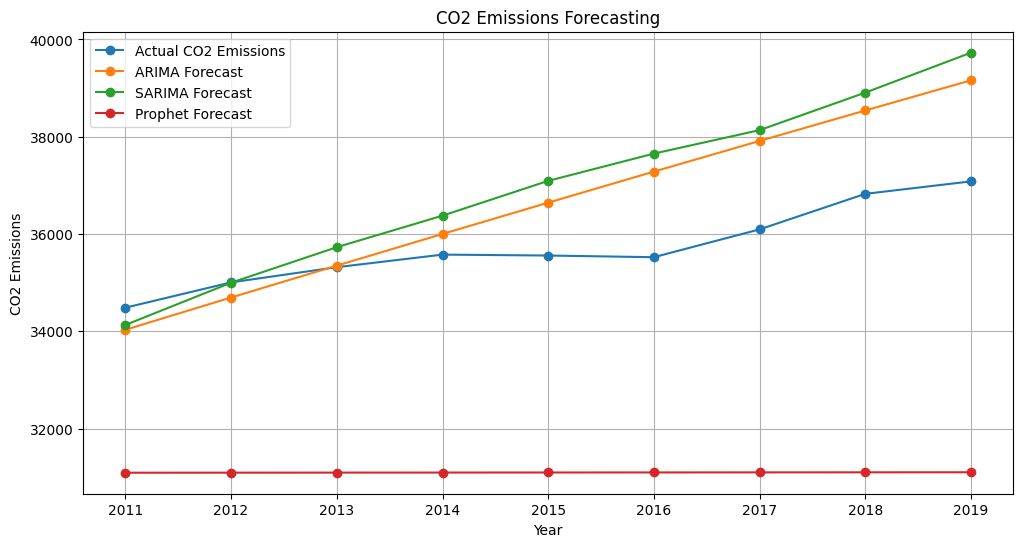

In [44]:
# Visualize Model Performance
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, actual_co2, label='Actual CO2 Emissions', marker='o')
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast', marker='o')
plt.plot(test_data.index, sarima_forecast, label='SARIMA Forecast', marker='o')
plt.plot(test_data.index, prophet_forecast, label='Prophet Forecast', marker='o')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecasting')
plt.legend()
plt.grid(True)
plt.show()

## Hyperparameters Tuning

In [186]:
# Split the data into train and test sets
train_data = df_owid_1900_onwards.loc['1900':'2014']
test_data = df_owid_1900_onwards.loc['2015': '2019']

In [187]:
# Hyperparameter tuning for ARIMA
best_arima_mae = float('inf')
best_arima_params = None

for p in range(3):
    for d in range(2):
        for q in range(3):
            arima_model = SARIMAX(train_data['co2'], order=(p, d, q), seasonal_order=(0, 0, 0, 0))
            arima_fit = arima_model.fit()
            arima_forecast = arima_fit.get_forecast(steps=len(test_data))

            arima_mae = mean_absolute_error(test_data['co2'], arima_forecast.predicted_mean)

            if arima_mae < best_arima_mae:
                best_arima_mae = arima_mae
                best_arima_params = (p, d, q)

# Hyperparameter tuning for SARIMA using auto_arima
sarima_model = auto_arima(train_data['co2'], start_p=0, d=None, start_q=0, max_p=10, max_d=10, max_q=10,
                          seasonal=True, suppress_warnings=True, stepwise=True, error_action='ignore')

best_sarima_order = sarima_model.order
best_sarima_seasonal_order = sarima_model.seasonal_order

# Fit and forecast using the best parameters
best_arima_model = SARIMAX(train_data['co2'], order=best_arima_params, seasonal_order=(0, 0, 0, 0))
best_arima_fit = best_arima_model.fit()
arima_forecast = best_arima_fit.get_forecast(steps=len(test_data))

best_sarima_model = SARIMAX(train_data['co2'], order=best_sarima_order, seasonal_order=best_sarima_seasonal_order)
best_sarima_fit = best_sarima_model.fit()
sarima_forecast = best_sarima_fit.get_forecast(steps=len(test_data))

# Evaluate ARIMA model performance
arima_r2 = r2_score(test_data['co2'], arima_forecast.predicted_mean)
arima_me = np.mean(test_data['co2'] - arima_forecast.predicted_mean)
arima_mae = mean_absolute_error(test_data['co2'], arima_forecast.predicted_mean)
arima_mape = np.mean(np.abs((test_data['co2'] - arima_forecast.predicted_mean) / test_data['co2'])) * 100

print("ARIMA Model R2:", arima_r2)
print("ARIMA Model ME:", arima_me)
print("ARIMA Model MAE:", arima_mae)
print("ARIMA Model MAPE:", arima_mape)
print(" ")

# Evaluate SARIMA model performance
sarima_r2 = r2_score(test_data['co2'], sarima_forecast.predicted_mean)
sarima_me = np.mean(test_data['co2'] - sarima_forecast.predicted_mean)
sarima_mae = mean_absolute_error(test_data['co2'], sarima_forecast.predicted_mean)
sarima_mape = np.mean(np.abs((test_data['co2'] - sarima_forecast.predicted_mean) / test_data['co2'])) * 100

print("SARIMA Model R2:", sarima_r2)
print("SARIMA Model ME:", sarima_me)
print("SARIMA Model MAE:", sarima_mae)
print("SARIMA Model MAPE:", sarima_mape)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency inform

ARIMA Model R2: 0.14117482875284237
ARIMA Model ME: 264.22044912783605
ARIMA Model MAE: 487.73243927147996
ARIMA Model MAPE: 1.3330093417848115
 
SARIMA Model R2: -3.1122314675940936
SARIMA Model ME: -1262.7002273694611
SARIMA Model MAE: 1262.7002273694611
SARIMA Model MAPE: 3.4780237069453253


In [188]:
# Prepare the data for Prophet
prophet_data = train_data.reset_index().rename(columns={'year': 'ds', 'co2': 'y'})

# Define hyperparameters for tuning
changepoint_prior_scales = [0.01, 0.1, 0.5]
seasonality_prior_scales = [0.01, 0.1, 1.0]
holidays_prior_scales = [0.01, 0.1, 1.0]

best_rmse = float('inf')
best_model = None
best_params = {}

# Perform hyperparameter tuning
for changepoint_prior_scale in changepoint_prior_scales:
    for seasonality_prior_scale in seasonality_prior_scales:
        for holidays_prior_scale in holidays_prior_scales:
            model = Prophet(changepoint_prior_scale=changepoint_prior_scale,
                            seasonality_prior_scale=seasonality_prior_scale,
                            holidays_prior_scale=holidays_prior_scale)
            model.fit(prophet_data)

            # Create a dataframe for future forecasting
            future = model.make_future_dataframe(periods=len(test_data), freq='Y')

            # Forecast CO2 emissions
            prophet_forecast = model.predict(future)

            # Evaluate metrics
            mae = mean_absolute_error(test_data['co2'], prophet_forecast['yhat'][-len(test_data):])
            mse = mean_squared_error(test_data['co2'], prophet_forecast['yhat'][-len(test_data):])
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((test_data['co2'] - prophet_forecast['yhat'][-len(test_data):]) / test_data['co2'])) * 100

            # Check if this configuration is the best
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_params = {
                    'changepoint_prior_scale': changepoint_prior_scale,
                    'seasonality_prior_scale': seasonality_prior_scale,
                    'holidays_prior_scale': holidays_prior_scale
                }

print("Best Hyperparameters:", best_params)
print("Best RMSE:", best_rmse)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphc40tdfe/8y060xxo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphc40tdfe/thc9_k7h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27539', 'data', 'file=/tmp/tmphc40tdfe/8y060xxo.json', 'init=/tmp/tmphc40tdfe/thc9_k7h.json', 'output', 'file=/tmp/tmphc40tdfe/prophet_modelhvj6ubvn/prophet_model-20230815175816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-188-a0eb96b8d3db>:32: Run

Best Hyperparameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01}
Best RMSE: 495.62914702275583


<ipython-input-188-a0eb96b8d3db>:32: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.



In [189]:
# Use the best model for forecasting
best_prophet_model = Prophet(**best_params)
best_prophet_model.fit(prophet_data)

# Create a dataframe for future forecasting
future = best_prophet_model.make_future_dataframe(periods=len(test_data), freq='Y')

# Forecast CO2 emissions using the best model
prophet_forecast = best_prophet_model.predict(future)

# Evaluate the best Prophet model performance
prophet_r2 = r2_score(test_data['co2'], prophet_forecast['yhat'][-len(test_data):])
prophet_me = np.mean(test_data['co2'] - prophet_forecast['yhat'][-len(test_data):])
prophet_mae = mean_absolute_error(test_data['co2'], prophet_forecast['yhat'][-len(test_data):])
prophet_mape = np.mean(np.abs((test_data['co2'] - prophet_forecast['yhat'][-len(test_data):]) / test_data['co2'])) * 100

print("Best Prophet Model R2:", prophet_r2)
print("Best Prophet Model ME:", prophet_me)
print("Best Prophet Model MAE:", prophet_mae)
print("Best Prophet Model MAPE:", prophet_mape)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphc40tdfe/o7ll2fem.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphc40tdfe/q83__67q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1449', 'data', 'file=/tmp/tmphc40tdfe/o7ll2fem.json', 'init=/tmp/tmphc40tdfe/q83__67q.json', 'output', 'file=/tmp/tmphc40tdfe/prophet_modelj01vkpj1/prophet_model-20230815175822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best Prophet Model R2: 0.4004696730251941
Best Prophet Model ME: nan
Best Prophet Model MAE: 443.04721543727794
Best Prophet Model MAPE: nan


<ipython-input-189-6a16d9000a1b>:15: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.



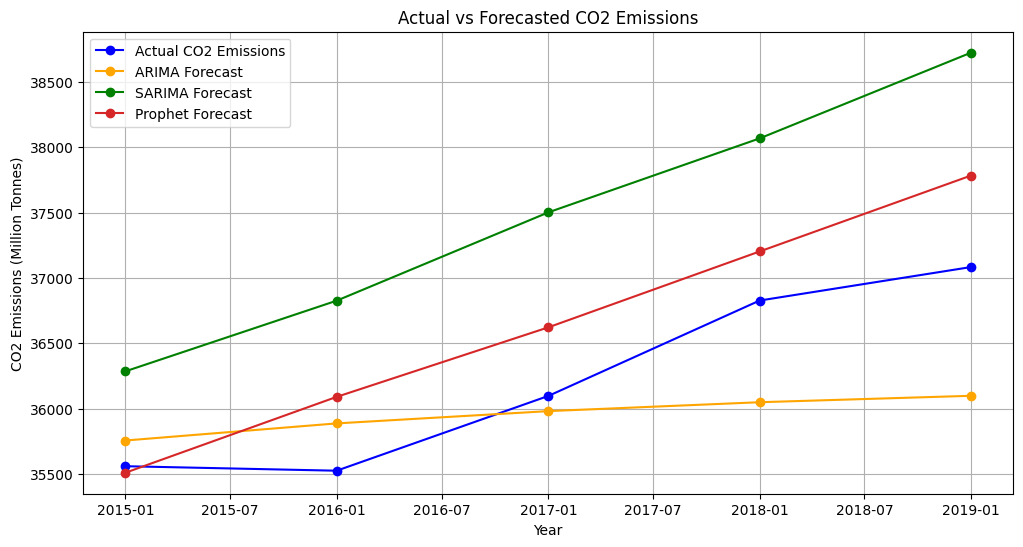

In [190]:
# Plot actual CO2 emissions
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['co2'], label='Actual CO2 Emissions', color='blue', marker = 'o')

# Plot ARIMA forecast
plt.plot(test_data.index, arima_forecast.predicted_mean, label='ARIMA Forecast', color='orange', marker = 'o')

# Plot SARIMA forecast
plt.plot(test_data.index, sarima_forecast.predicted_mean, label='SARIMA Forecast', color='green', marker = 'o')

# Plot Prophet forecast
plt.plot(test_data.index, prophet_forecast['yhat'][-len(test_data):], label='Prophet Forecast', color='tab:red', marker = 'o')

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (Million Tonnes)')
plt.title('Actual vs Forecasted CO2 Emissions')
plt.legend()
plt.grid(True)
plt.show()

In [191]:
# Extend the time index for forecasting
forecast_years = [max(train_data.index) + pd.DateOffset(years=i) for i in [10, 20, 30, 40, 50]]

# Forecast using ARIMA
arima_forecasts = best_arima_fit.get_forecast(steps=len(forecast_years))
arima_forecast_df = arima_forecasts.predicted_mean.to_frame(name='ARIMA Forecast')
arima_forecast_df.index = forecast_years

# Forecast using SARIMA
sarima_forecasts = best_sarima_fit.get_forecast(steps=len(forecast_years))
sarima_forecast_df = sarima_forecasts.predicted_mean.to_frame(name='SARIMA Forecast')
sarima_forecast_df.index = forecast_years

# Fit the Prophet model on historical data
prophet_model = Prophet()
prophet_model.fit(train_data.reset_index().rename(columns={'year': 'ds', 'co2': 'y'}))

# Create future dates for Prophet
forecast_years = [max(train_data.index).year + i for i in [10, 20, 30, 40, 50]]
prophet_future = pd.DataFrame({'ds': pd.to_datetime(forecast_years, format='%Y')})

# Forecast using Prophet
prophet_forecasts = prophet_model.predict(prophet_future)
prophet_forecast_df = prophet_forecasts[['ds', 'yhat']].rename(columns={'ds': 'Year', 'yhat': 'Prophet Forecast'})
prophet_forecast_df.set_index('Year', inplace=True)


# Combine forecasts into a single dataframe
all_forecasts = pd.concat([arima_forecast_df, sarima_forecast_df, prophet_forecast_df], axis=1)

display(all_forecasts)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphc40tdfe/7xdt4u8z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphc40tdfe/kbix8kyc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79482', 'data', 'file=/tmp/tmphc40tdfe/7xdt4u8z.json', 'init=/tmp/tmphc40tdfe/kbix8kyc.json', 'output', 'file=/tmp/tmphc40tdfe/prophet_modelfknto68d/prophet_model-20230815175823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ARIMA Forecast,SARIMA Forecast,Prophet Forecast
2024-01-01,35755.292176,36284.832237,39348.188898
2034-01-01,35886.244799,36825.369053,44281.493086
2044-01-01,35980.194866,37501.525633,49382.031467
2054-01-01,36048.285656,38067.387934,54315.335655
2064-01-01,36097.442257,38722.948282,59415.874037


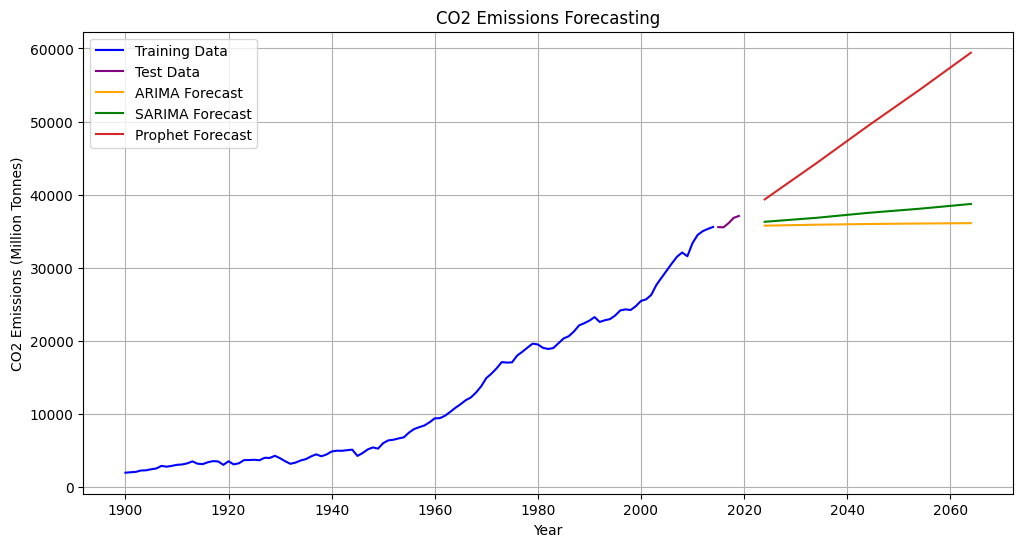

In [192]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['co2'], label='Training Data', color='blue') # , marker = 'o'
plt.plot(test_data.index, test_data['co2'], label='Test Data', color='purple') # , marker = 'o'
plt.plot(all_forecasts.index, all_forecasts['ARIMA Forecast'], label='ARIMA Forecast', color='orange') # , marker = 'o'
plt.plot(all_forecasts.index, all_forecasts['SARIMA Forecast'], label='SARIMA Forecast', color='green')  # , marker = 'o'
plt.plot(all_forecasts.index, all_forecasts['Prophet Forecast'], label='Prophet Forecast', color='tab:red') # , marker = 'o'
plt.title('CO2 Emissions Forecasting')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (Million Tonnes)')
plt.legend()
plt.grid(True)
plt.show()